In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message="X has feature names, but StandardScaler was fitted without feature names")


# Data Preparation

In [2]:
# For Google Colab
TrainSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TrainData.pickle"
TestSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TestData.pickle"

FileSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/allData.pickle"
ScalerPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Scaler.pickle"
ModelPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Model.pickle"

In [3]:
# For Local
# TrainSource = "./GeneratedData/TrainData.pickle"
# TestSource = "./GeneratedData/TestData.pickle"

# FileSource = "./GeneratedData4CO/allData.pickle"
FileSource = "./GeneratedDataDouble/allData.pickle"
NYC_FileSource = "./GeneratedDataDouble/NYC_allData.pickle"
ISR_FileSource = "./GeneratedDataDouble/ISR_allData.pickle"

ScalerPath = "./GeneratedData4CO/Scaler.pickle"
AccelRNNModelPath = "./GeneratedData4CO/AccelRNNModel.pickle"
NYC_AccelRNNModelPath = "./GeneratedData4CO/NYC_AccelRNNModel.pickle"
ISR_AccelRNNModelPath = "./GeneratedData4CO/ISR_AccelRNNModel.pickle"
# CORNNModelPath = "./GeneratedData/CORNNModel.pickle"

In [4]:
HeaderWithoutAccel = ["ApproachRateOther", 
                      "Rel_Pos_Magnitude", 
                      "Steer2", 
                      "1_Head_Center_Distance", "2_Head_Center_Distance", 
                      "Filtered_2_Head_Velocity_Total",
                      "1_Turn",
                      "2_Indicator",
                      "Centerline_Offset_2",
                      "RelativeRotation"] # Signaling ()

# outputHeader = ["Centerline_Offset_A"]
outputHeader = ["Accel1"]
                
input_size = len(HeaderWithoutAccel)
output_size = len(outputHeader)

In [5]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length


        # GRU layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * seq_length, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Reshape output to fit the fully connected layer
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [6]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = targets.iloc[i + seq_length].values[0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Load and preprocess data from each file
def preprocess_data(files, seq_length):
    all_sequences = np.empty((0,seq_length,len(HeaderWithoutAccel)))
    all_targets = np.empty(0)

    for file_path in files:
        data = pd.read_feather(file_path)
        features = data[HeaderWithoutAccel]
        targets = data[outputHeader]
        scaled_features = scaler.transform(features)
        sequences, targetsVector = create_sequences(scaled_features,targets, seq_length)
        if(sequences.shape[0]==0):
          print("Skipping:", all_sequences.shape,sequences.shape)
          continue
        all_sequences = np.concatenate((all_sequences, sequences), axis=0)
        all_targets =  np.concatenate((all_targets, targetsVector), axis=0)

    return all_sequences,all_targets

In [7]:
def DrawPicture(file, net, Seq_Length):
  print(file)
  net.eval()
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  targets = data[outputHeader]
  scaled_features = scaler.transform(features)
  sequences, targetsVector = create_sequences(scaled_features, targets, Seq_Length)
  # print(sequences.shape)
  out = net(torch.Tensor(sequences)).detach().numpy()
  plt.plot(targetsVector,label='original Accel', color='b')
  plt.plot(out,label='predicted Accel', color='r')
  # plt.ylim(-1,1)
  plt.legend()
  plt.show()

In [8]:
def scaler_loader(ScalerPath, FileList):
    # ## First scale Input
    scaler=None
    if os.path.exists(ScalerPath):
        print('Using existed scaler.')
        with open(ScalerPath, 'rb') as file:
            scaler = pickle.load(file)
    else:
        print('Creating new scaler.')
        scaler = StandardScaler()
        for file_path in FileList:
            if not os.path.exists(file_path):
                print(f"Could not find{file_path}")
                continue
            data = pd.read_feather(file_path)
            features = data[HeaderWithoutAccel]
            scaler.partial_fit(features.values)
        with open(ScalerPath, 'wb') as file:
            pickle.dump(scaler, file)
    return scaler

# automation

In [9]:
def train_model_and_save(FileSource, ModelPath):
    # FileSource = "./GeneratedData/allData.pickle"
    # ModelPath = "./GeneratedData/AccelRNNModel.pickle"

    TrainSource = "./GeneratedData/TrainData.pickle"
    TestSource = "./GeneratedData/TestData.pickle"
    ScalerPath = "./GeneratedData/Scaler.pickle"

    # Define input and output
    HeaderWithoutAccel = ["ApproachRateOther", 
                        "Rel_Pos_Magnitude", 
                        "SteerB", 
                        "A_Head_Center_Distance", "B_Head_Center_Distance", 
                        "Filtered_B_Head_Velocity_Total",
                        "A_Turn",
                        "B_Indicator",
                        "Centerline_Offset_B",
                        "RelativeRotation"] # Signaling ()
    outputHeader = ["AccelA"]
                    
    input_size = len(HeaderWithoutAccel)
    output_size = len(outputHeader)

    # Load data
    FileList=[]
    with open(FileSource,'rb') as f:
        FileList = pickle.load(f)
        
    # Load scaler
    scaler = scaler_loader(ScalerPath, FileList)
            
    # Calculate sequence length
    Seq_Length = 5
    TargetTimeLength = 0.75 ## in seconds

    timeDiffArray=np.empty(0)
    for file_path in FileList:
        if not os.path.exists(file_path):
            print(f"Could not find{file_path}")
            continue
        data = pd.read_feather(file_path)
        timeDiffArray = np.append(timeDiffArray, np.diff(data["ScenarioTime"]))
    Seq_Length = int(np.floor(TargetTimeLength/np.mean(timeDiffArray)))

    # Split training and testing data
    train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

    batch_size = 64
    # Prepare the DataLoaders:
    train_sequences, train_labels = preprocess_data(train_files, Seq_Length)
    test_sequences, test_labels = preprocess_data(test_files, Seq_Length)

    # Convert to PyTorch tensors
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.float32)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.float32)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(train_sequences, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(test_sequences, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create an instance of the network
    num_epochs = 3
    hidden_size = 64
    num_layers = 1

    net = GRUModel(len(HeaderWithoutAccel), hidden_size, output_size, Seq_Length, num_layers)
    criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  # Adding L2 regularization

    train_losses = []
    test_losses = []

    #TODO: Create empty arrays for both Test and Training Loss (based on batch size)
    for epoch in range(num_epochs):
        net.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()

            outputs = net(inputs)
            outputs = outputs.squeeze()
            #print(outputs.shape,targets.shape)
            loss = criterion(outputs, targets)  # Make sure targets are the correct shape
            loss.backward()
            optimizer.step()
            # TODO: Record training loss for each Batch
            train_losses.append(loss.item())
            # TODO: Ammend the arrays from above

        net.eval()
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                outputs = net(inputs)
                
                # TODO: Record test loss for each Batch
                batch_loss = criterion(outputs, targets).item()
                test_loss += batch_loss
                test_losses.append(batch_loss)  # Record test loss for each batch
                
                # test_loss += criterion(outputs, targets).item()  # Sum up batch loss
                
                # TODO: Ammend the arrays from above
            test_loss /= len(test_loader.dataset)
        print(f'Test Loss: {test_loss}')

        # Print out the epoch number
        print(f"Epoch {epoch+1}/{num_epochs} completed")
    
    #TODO: plot the two arrays (be carefull they will not be the same length) Stretch the smaller oine it should fit approximatly
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test Loss')  # Stretching the test loss plot
    plt.title('Training and Test Losses')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    DrawPicture('./GeneratedData4CO/CP5_NYC37.feather', net, Seq_Length)
    
    # torch.save(net.state_dict(), ModelPath)
    
    return net

In [10]:
def EvaluateModel(FileSource, net):
    # Load data
    FileList=[]
    with open(FileSource,'rb') as f:
        FileList = pickle.load(f)
        
    # Load scaler
    scaler = scaler_loader(ScalerPath, FileList)
    
    # Calculate sequence length
    Seq_Length = 5
    TargetTimeLength = 0.75 ## in seconds

    timeDiffArray=np.empty(0)
    for file_path in FileList:
        if not os.path.exists(file_path):
            print(f"Could not find{file_path}")
            continue
        data = pd.read_feather(file_path)
        timeDiffArray = np.append(timeDiffArray, np.diff(data["ScenarioTime"]))
    Seq_Length = int(np.floor(TargetTimeLength/np.mean(timeDiffArray)))

    # Split training and testing data
    train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

    # Evaluate all Files
    OutDict={}
    for file in FileList:
        data = pd.read_feather(file)
        features = data[HeaderWithoutAccel]
        original = data[outputHeader]
        scaled_features = scaler.transform(features)
        sequences, orin = create_sequences(scaled_features,original, Seq_Length)
        if(sequences.shape[0]==0):
            print("Not enoughData:",file)
            continue
        out = net(torch.Tensor(sequences)).detach().numpy()
        out = out.squeeze()
        value = np.power((orin-out),2).sum()/out.shape[0]
        OutDict[file] = value
    
    OutDict = dict(sorted(OutDict.items(), key=lambda item: item[1], reverse=True))
    
    # print("----- WORST-----")
    # DrawPicture(list(OutDict.keys())[0], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[1], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[2], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[3], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[4], net, Seq_Length)
    # print("----- BEST-----")
    # DrawPicture(list(OutDict.keys())[-1], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[-2], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[-3], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[-4], net, Seq_Length)
    # DrawPicture(list(OutDict.keys())[-5], net, Seq_Length)

    # Evaluate only test and training files
    TrainOutDict={}
    TestOutDict={}
    for file in train_files:
        data = pd.read_feather(file)
        features = data[HeaderWithoutAccel]
        original = data[outputHeader]
        scaled_features = scaler.transform(features.values)
        sequences, orin = create_sequences(scaled_features,original, Seq_Length)
        if(sequences.shape[0]==0):
            print("Not enoughData:",file)
            continue
        out= net(torch.Tensor(sequences)).detach().numpy()
        out = out.squeeze()
        value = np.power((orin-out),2).sum()/out.shape[0]
        TrainOutDict[file] = value

    for file in test_files:
        data = pd.read_feather(file)
        features = data[HeaderWithoutAccel]
        original = data[outputHeader]
        scaled_features = scaler.transform(features.values)
        sequences, orin = create_sequences(scaled_features,original, Seq_Length)
        if(sequences.shape[0]==0):
            print("Not enoughData:",file)
            continue
        out= net(torch.Tensor(sequences)).detach().numpy()
        out = out.squeeze()
        value = np.power((orin-out),2).sum()/out.shape[0]
        TestOutDict[file] = value
        
    array = np.array([*OutDict.values()], dtype=object)
    TrainValues = np.array([*TrainOutDict.values()], dtype=object)
    TestValues = np.array([*TestOutDict.values()], dtype=object)
    bin_edges = np.histogram(array,bins=25)[1]
    plt.hist(TrainOutDict.values(), bin_edges, color='blue',label="train data")
    plt.hist(TestOutDict.values(), bin_edges, color='red',label="test data")
    plt.title("Histogram of prediction-original distance for both Training and Test data")
    plt.legend()
    plt.show()
    
    print("----- WORST-----")
    DrawPicture(list(TestOutDict.keys())[0], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[1], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[2], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[3], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[4], net, Seq_Length)
    print("----- BEST-----")
    DrawPicture(list(TestOutDict.keys())[-1], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[-2], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[-3], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[-4], net, Seq_Length)
    DrawPicture(list(TestOutDict.keys())[-5], net, Seq_Length)

In [11]:
alldata_net = train_model_and_save(FileSource, AccelRNNModelPath)

Using existed scaler.


NameError: name 'scaler' is not defined

Using existed scaler.


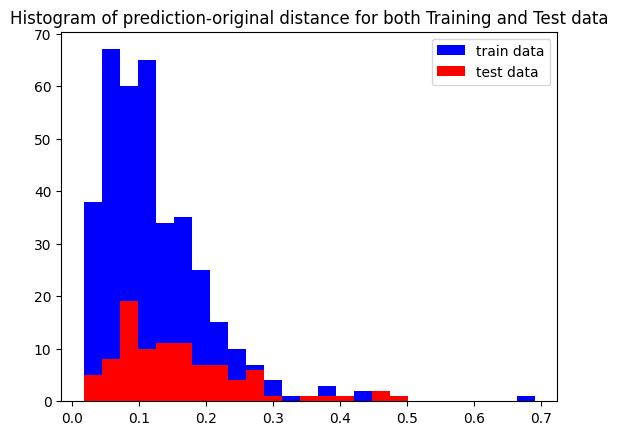

----- WORST-----
./GeneratedData4CO/CP5_NYC15.feather


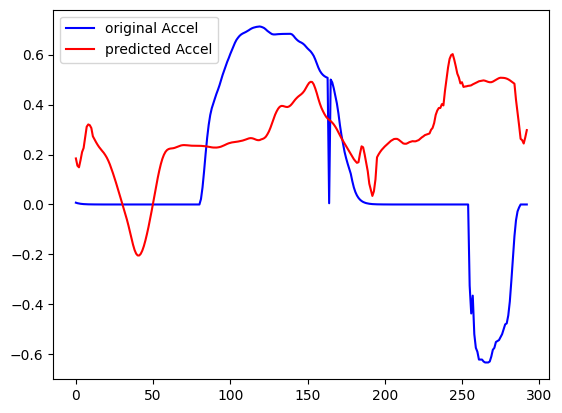

./GeneratedData4CO/CP5_NYC24.feather


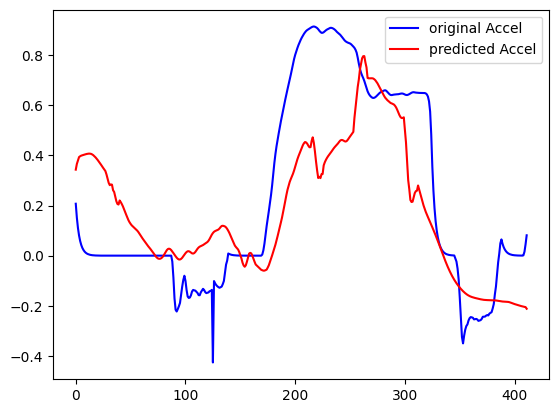

./GeneratedData4CO/CP3_NYC40.feather


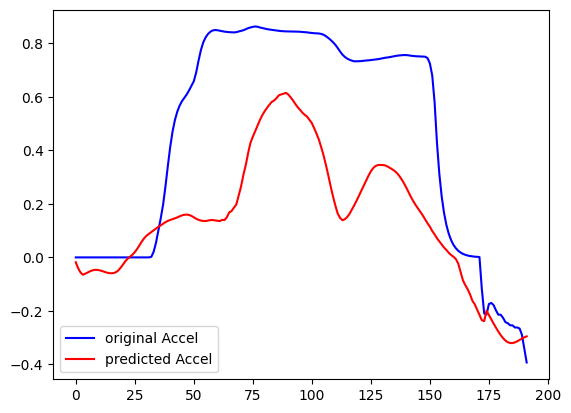

./GeneratedData4CO/CP3_NYC35.feather


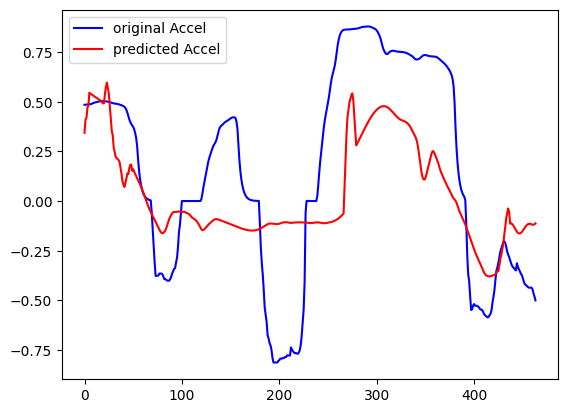

./GeneratedData4CO/CP2_ISR05.feather


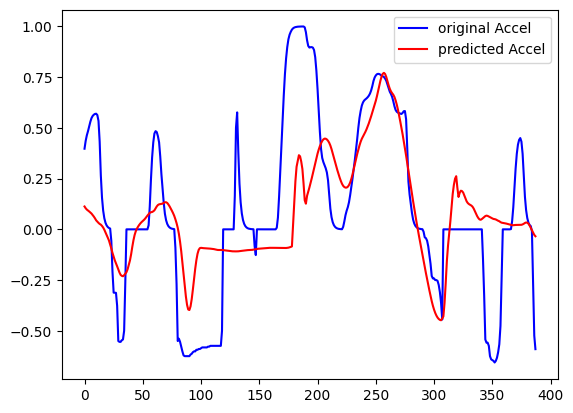

----- BEST-----
./GeneratedData4CO/CP5_ISR02.feather


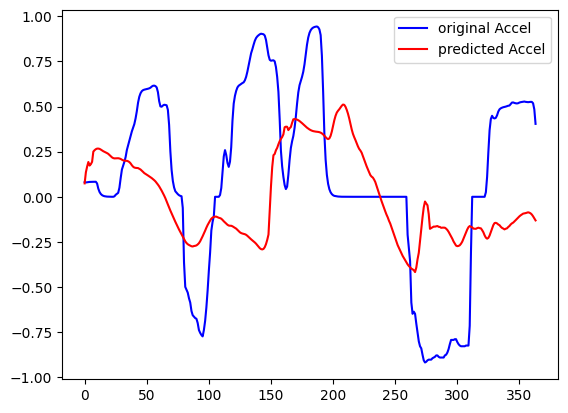

./GeneratedData4CO/CP1_ISR20.feather


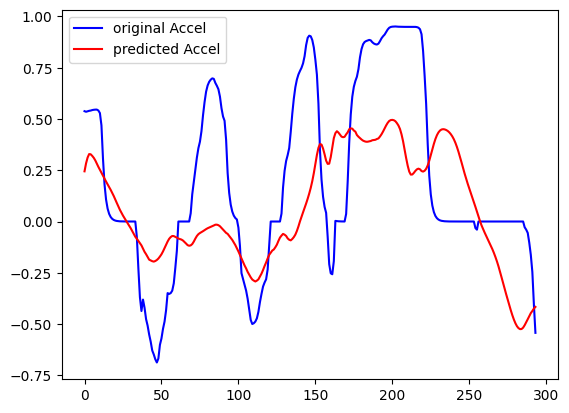

./GeneratedData4CO/CP5_ITH5.feather


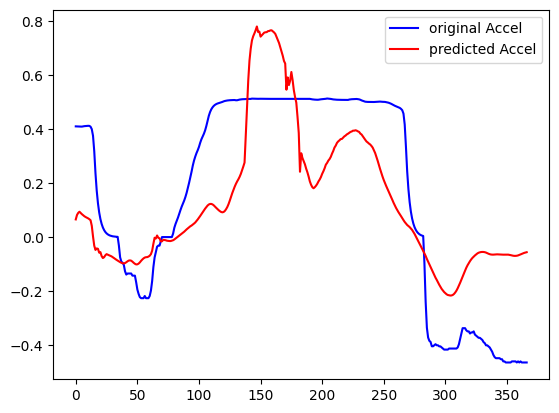

./GeneratedData4CO/CP8_NYC6.feather


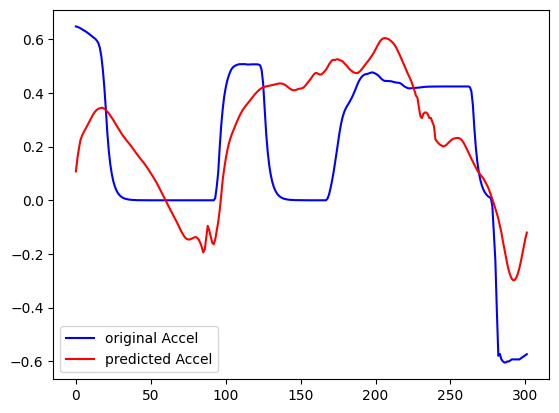

./GeneratedData4CO/CP7_ITH1.feather


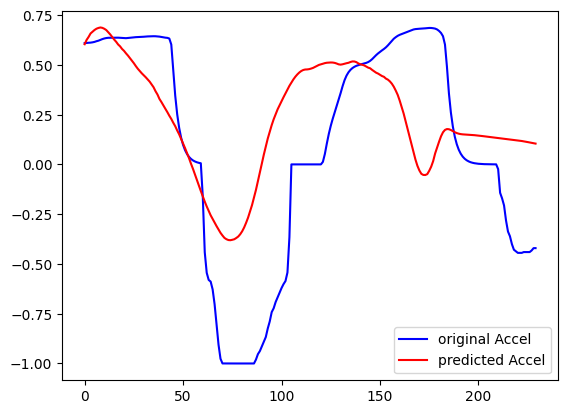

In [152]:
EvaluateModel(FileSource, alldata_net)

Using existed scaler.


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.002459447176599036
Epoch 1/3 completed
Test Loss: 0.002570297042078803
Epoch 2/3 completed
Test Loss: 0.002822986845138621
Epoch 3/3 completed


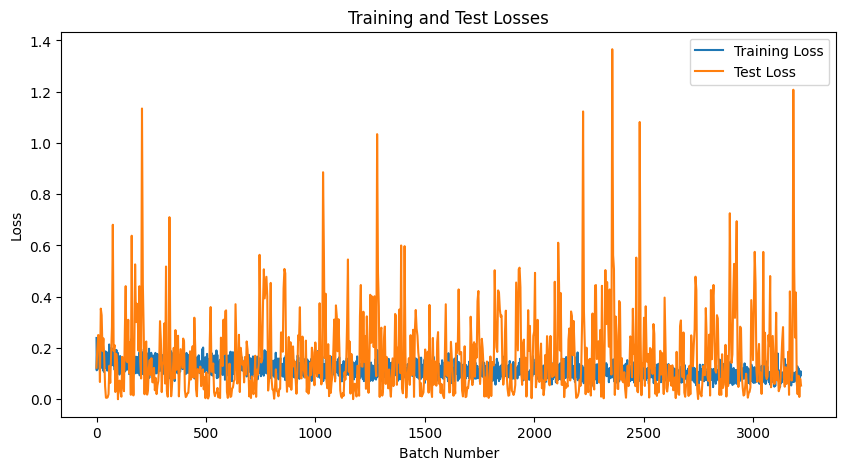

./GeneratedData4CO/CP5_NYC37.feather


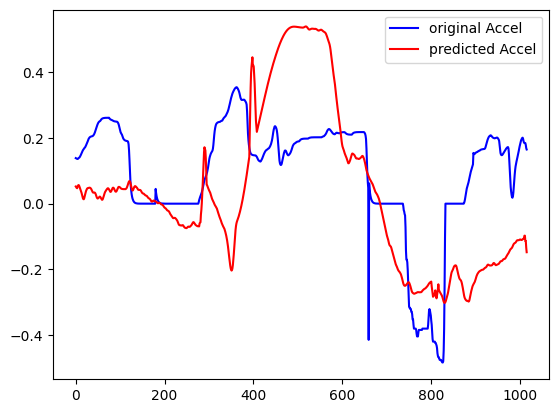

In [147]:
NYC_net = train_model_and_save(NYC_FileSource, NYC_AccelRNNModelPath)

Creating new scaler.


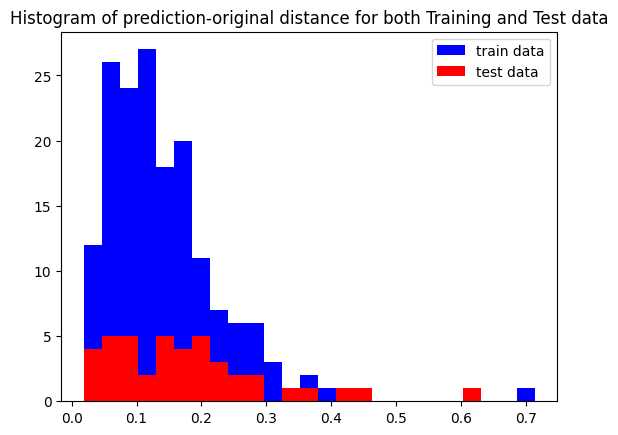

----- WORST-----
./GeneratedData4CO/CP2_NYC40.feather


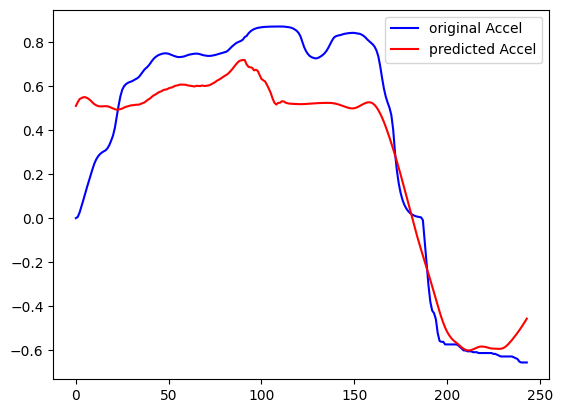

./GeneratedData4CO/CP7_NYC3.feather


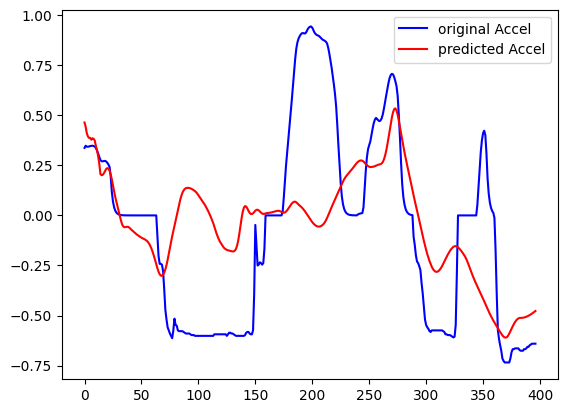

./GeneratedData4CO/CP6_NYC37.feather


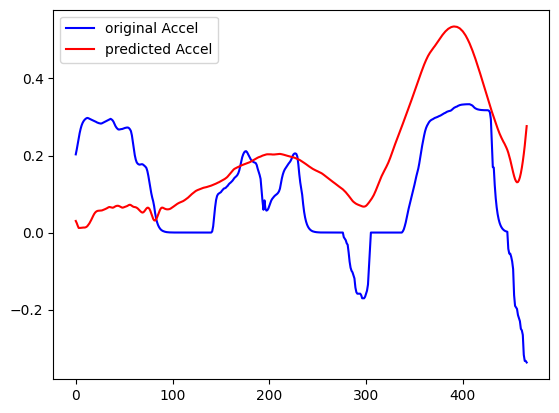

./GeneratedData4CO/CP6_NYC14.feather


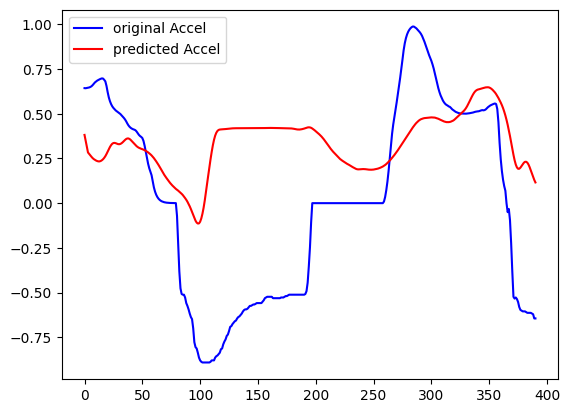

./GeneratedData4CO/CP8_NYC7.feather


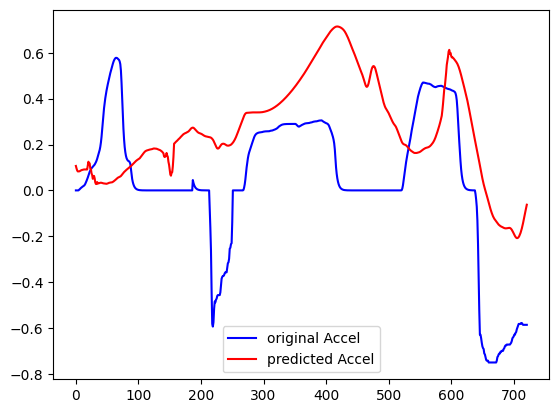

----- BEST-----
./GeneratedData4CO/CP1_NYC29.feather


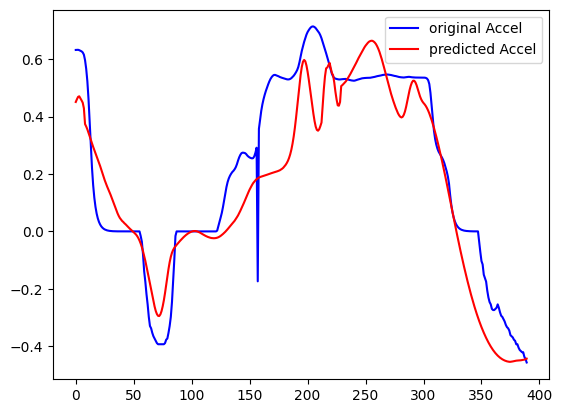

./GeneratedData4CO/CP7_NYC14.feather


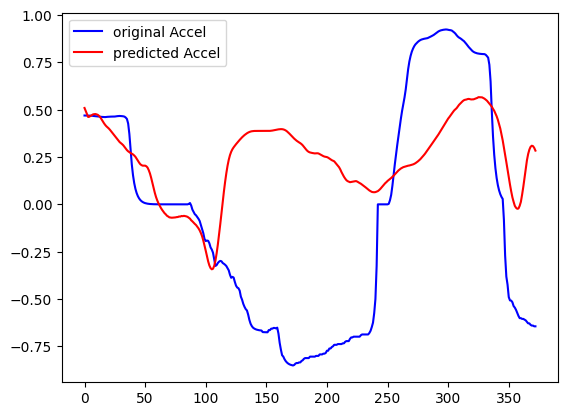

./GeneratedData4CO/CP8_NYC29.feather


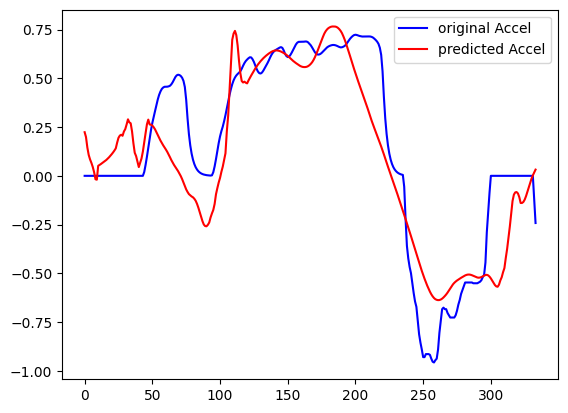

./GeneratedData4CO/CP5_NYC39.feather


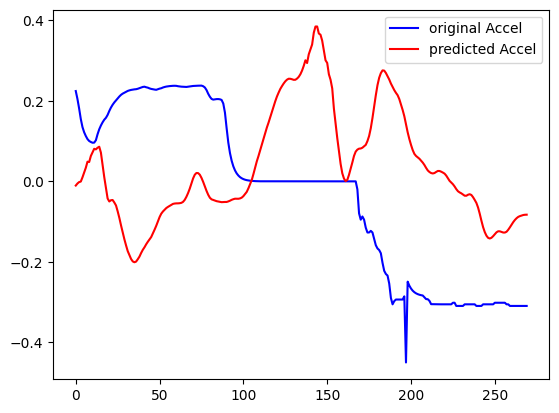

./GeneratedData4CO/CP5_NYC38.feather


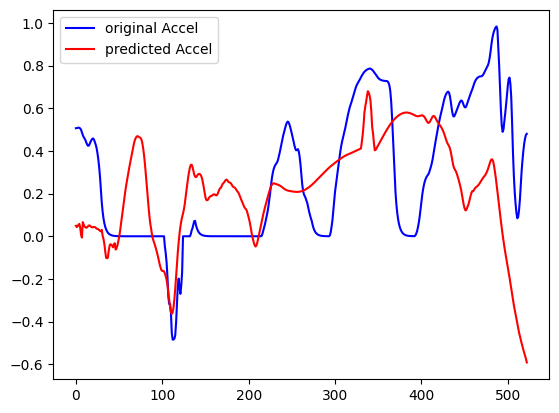

In [148]:
EvaluateModel(NYC_FileSource, NYC_net)

Using existed scaler.


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.002210430267281865
Epoch 1/3 completed
Test Loss: 0.002096037435481578
Epoch 2/3 completed
Test Loss: 0.00213605188991366
Epoch 3/3 completed


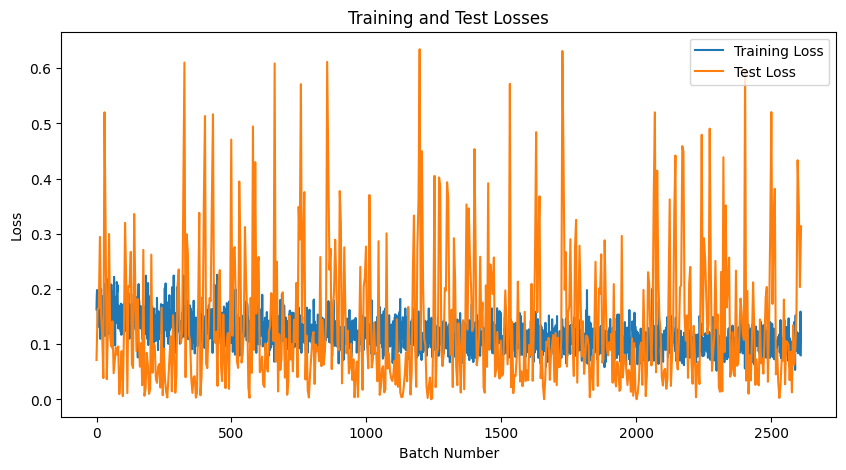

./GeneratedData4CO/CP5_NYC37.feather


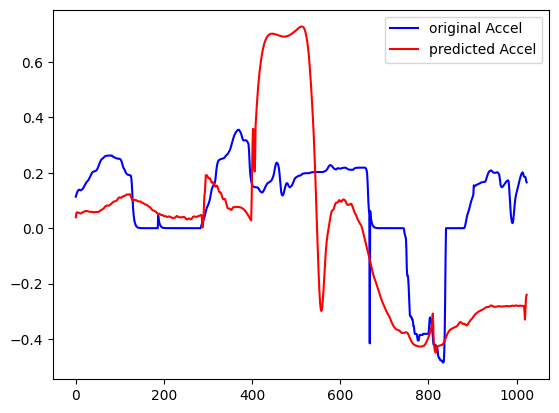

In [149]:
ISR_net = train_model_and_save(ISR_FileSource, ISR_AccelRNNModelPath)

Using existed scaler.


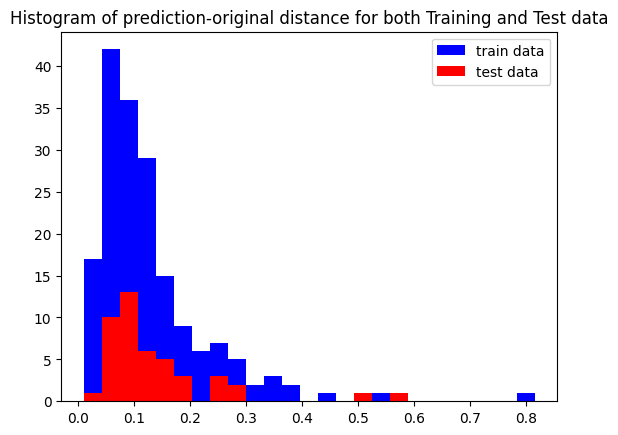

----- WORST-----
./GeneratedData4CO/CP8_ISR28.feather


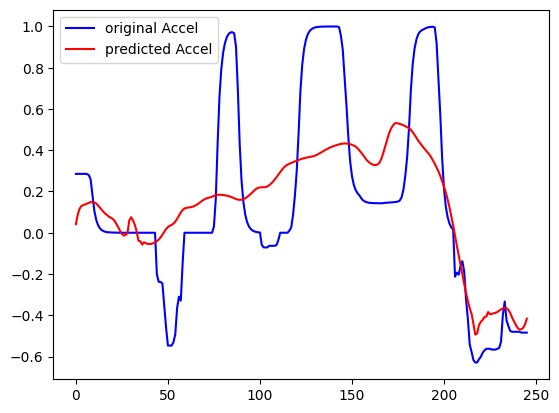

./GeneratedData4CO/CP1_ISR11.feather


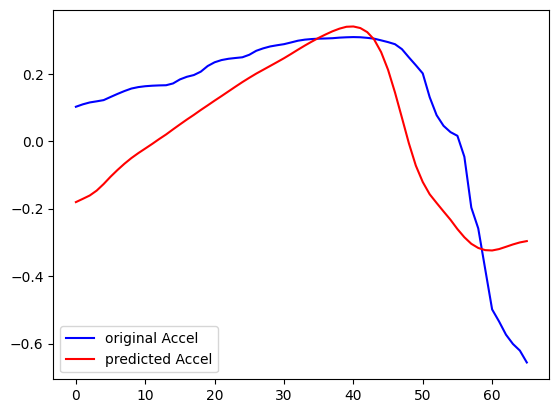

./GeneratedData4CO/CP8_ISR38.feather


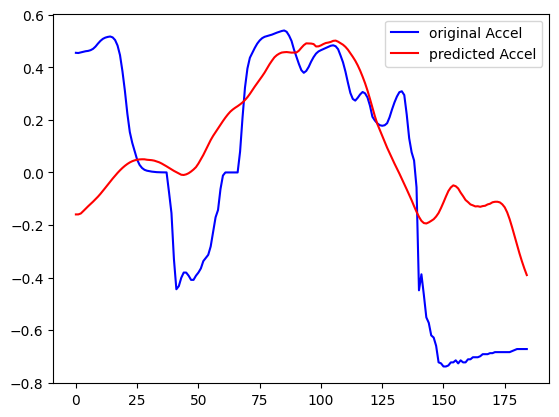

./GeneratedData4CO/CP2_ISR02.feather


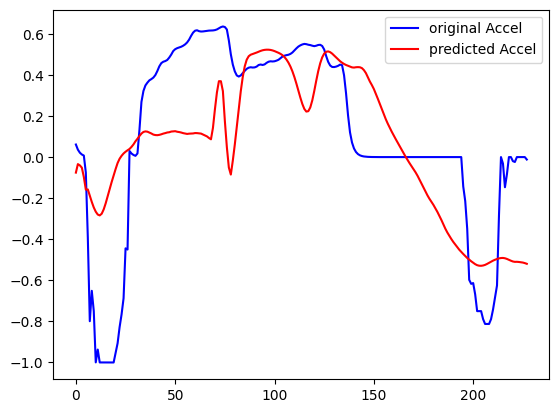

./GeneratedData4CO/CP1_ISR14.feather


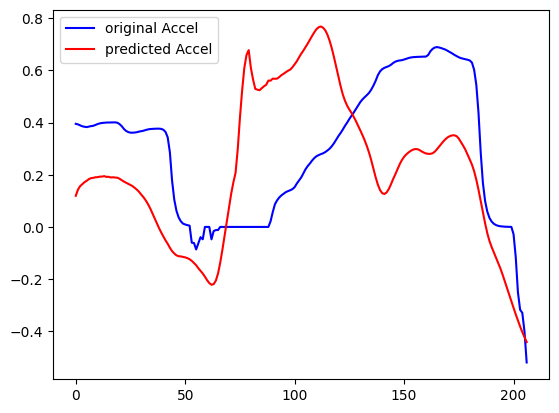

----- BEST-----
./GeneratedData4CO/CP7_ISR31.feather


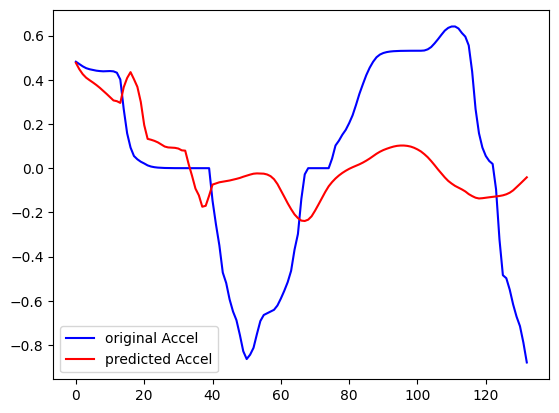

./GeneratedData4CO/CP8_ISR07.feather


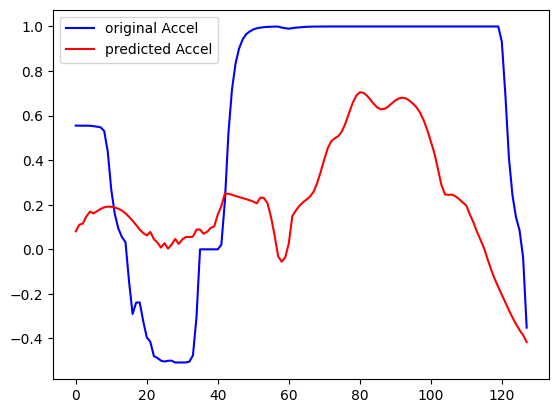

./GeneratedData4CO/CP3_ISR10.feather


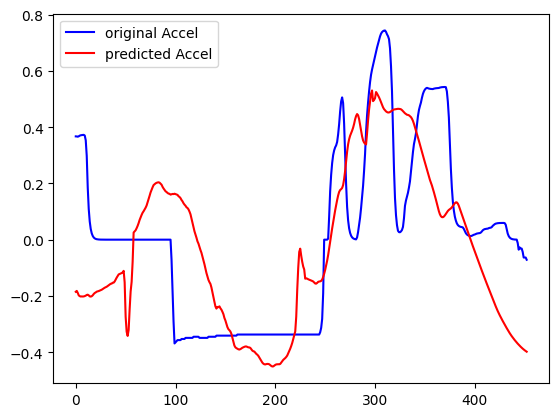

./GeneratedData4CO/CP1_ISR33.feather


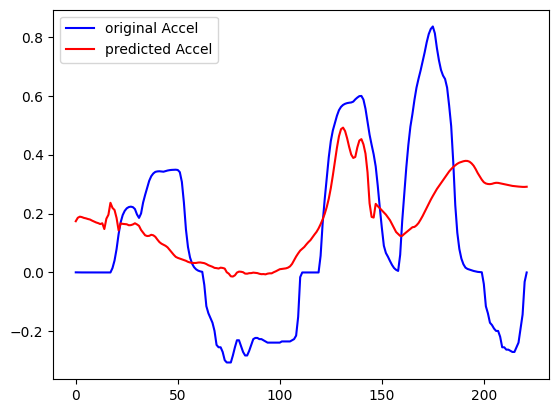

./GeneratedData4CO/CP1_ISR36.feather


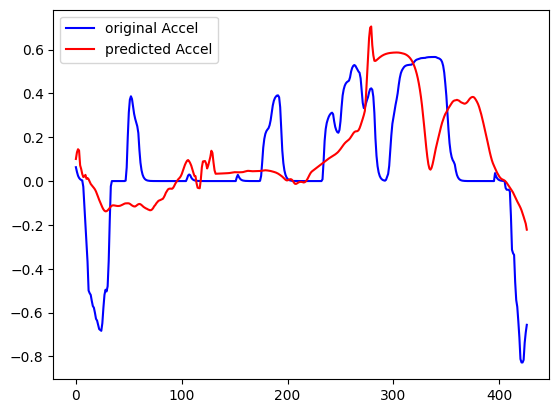

In [150]:
EvaluateModel(ISR_FileSource, ISR_net)

# Original

In [9]:
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

In [10]:
## First scale Input
scaler=None
if os.path.exists(ScalerPath):
  with open(ScalerPath, 'rb') as file:
    scaler = pickle.load(file)
else:
  scaler = StandardScaler()
  for file_path in FileList:
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    features = data[HeaderWithoutAccel]
    scaler.partial_fit(features.values)
  with open(ScalerPath, 'wb') as file:
    pickle.dump(scaler, file)

In [11]:
Seq_Length = 5
TargetTimeLength = 0.75 ## in seconds

timeDiffArray=np.empty(0)
for file_path in FileList:
    if not os.path.exists(file_path):
      print(f"Could not find{file_path}")
      continue
    data = pd.read_feather(file_path)
    timeDiffArray = np.append(timeDiffArray, np.diff(data["ScenarioTime"]))
Seq_Length = int(np.floor(TargetTimeLength/np.mean(timeDiffArray)))
Seq_Length

13

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length


        # GRU layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * seq_length, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Reshape output to fit the fully connected layer
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * seq_length, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Reshape output to fit the fully connected layer
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

# Train Model for all participants

In [13]:
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

In [14]:
## Leave one-out
## Replace the fully connected layer with a 1d - Conv

In [15]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = targets.iloc[i + seq_length].values[0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Load and preprocess data from each file
def preprocess_data(files, seq_length):
    all_sequences = np.empty((0,seq_length,len(HeaderWithoutAccel)))
    all_targets = np.empty(0)

    for file_path in files:
        data = pd.read_feather(file_path)
        features = data[HeaderWithoutAccel]
        targets = data[outputHeader]
        scaled_features = scaler.transform(features)
        sequences, targetsVector = create_sequences(scaled_features,targets, seq_length)
        if(sequences.shape[0]==0):
          print("Skipping:",all_sequences.shape,sequences.shape)
          continue
        all_sequences = np.concatenate((all_sequences, sequences), axis=0)
        all_targets =  np.concatenate((all_targets, targetsVector), axis=0)

    return all_sequences,all_targets

In [17]:
batch_size = 64
# Prepare the DataLoaders:
train_sequences, train_labels = preprocess_data(train_files, Seq_Length)
test_sequences, test_labels = preprocess_data(test_files, Seq_Length)

# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Grid Search

In [126]:
# List of hidden sizes and number of layers to try
hidden_sizes = [16, 32, 64]
num_layers_list = [1, 2, 3]

# Other parameters
input_size = len(HeaderWithoutAccel)
output_size = len(outputHeader)
seq_length = Seq_Length
num_epochs = 3

In [127]:
# Function to train and evaluate the model
def train_and_evaluate(hidden_size, num_layers):
    # Create an instance of the model
    net = GRUModel(input_size, hidden_size, output_size, seq_length, num_layers)
    # criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        net.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = net(inputs)
            test_loss += criterion(outputs, targets).item()
    test_loss /= len(test_loader.dataset)
    return test_loss

In [111]:
# Grid search over different combinations of hidden sizes and number of layers
import time
results = {}
for num_layers in num_layers_list:
    for hidden_size in hidden_sizes:
        start_time = time.now()
        test_loss = train_and_evaluate(hidden_size, num_layers)
        results[(hidden_size, num_layers)] = test_loss
        end_time = time.now()
        time_spent = end_time - start_time
        print(f"Hidden Size: {hidden_size}, Num Layers: {num_layers}, Test Loss: {test_loss}, time spent: {time_spent}")

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to

Hidden Size: 16, Num Layers: 1, Test Loss: 0.0014217599063209721
Hidden Size: 32, Num Layers: 1, Test Loss: 0.00142180201307616
Hidden Size: 64, Num Layers: 1, Test Loss: 0.0014205161371447822
Hidden Size: 16, Num Layers: 2, Test Loss: 0.0014152627832547044
Hidden Size: 32, Num Layers: 2, Test Loss: 0.00141754756552082
Hidden Size: 64, Num Layers: 2, Test Loss: 0.001417843295867724
Hidden Size: 16, Num Layers: 3, Test Loss: 0.0014194049724282664


KeyboardInterrupt: 

- epoch = 3 
    - Hidden Size: 16, Num Layers: 1, Test Loss: 0.001422987241729292
    - Hidden Size: 32, Num Layers: 1, Test Loss: 0.0014231149508187847
    - Hidden Size: 64, Num Layers: 1, Test Loss: 0.0014245221841484824
    - Hidden Size: 16, Num Layers: 2, Test Loss: 0.0014210970175370164
    - Hidden Size: 32, Num Layers: 2, Test Loss: 0.0014162531819610993
    - Hidden Size: 64, Num Layers: 2, Test Loss: 0.0014168495433174067
    - Hidden Size: 16, Num Layers: 3, Test Loss: 0.0014192529316132713
    - Hidden Size: 32, Num Layers: 3, Test Loss: 0.0014164710505014185
    - Hidden Size: 64, Num Layers: 3, Test Loss: 0.0014194900369097054
- epoch = 4
    - Hidden Size: 16, Num Layers: 1, Test Loss: 0.0014217599063209721
    - Hidden Size: 32, Num Layers: 1, Test Loss: 0.00142180201307616
    - Hidden Size: 64, Num Layers: 1, Test Loss: 0.0014205161371447822
    - Hidden Size: 16, Num Layers: 2, Test Loss: 0.0014152627832547044
    - Hidden Size: 32, Num Layers: 2, Test Loss: 0.00141754756552082
    - Hidden Size: 64, Num Layers: 2, Test Loss: 0.001417843295867724
    - Hidden Size: 16, Num Layers: 3, Test Loss: 0.0014194049724282664

# Actual Training

In [28]:
# Create an instance of the network
num_epochs = 4
hidden_size = 16
num_layers = 2

net = LSTMModel(len(HeaderWithoutAccel), hidden_size, output_size, Seq_Length, num_layers)
# net = GRUModel(len(HeaderWithoutAccel), hidden_size, output_size, Seq_Length, num_layers)
# criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  # Adding L2 regularization

In [29]:
train_losses = []
test_losses = []

#TODO: Create empty arrays for both Test and Training Loss (based on batch size)
for epoch in range(num_epochs):
    net.train()
    for inputs, targets in train_loader:
      optimizer.zero_grad()

      outputs = net(inputs)
      outputs = outputs.squeeze()
      #print(outputs.shape,targets.shape)
      loss = criterion(outputs, targets)  # Make sure targets are the correct shape
      loss.backward()
      optimizer.step()
      # TODO: Record training loss for each Batch
      train_losses.append(loss.item())
      # TODO: Ammend the arrays from above

    net.eval()
    with torch.no_grad():
      test_loss = 0
      for inputs, targets in test_loader:
        outputs = net(inputs)
        
        # TODO: Record test loss for each Batch
        batch_loss = criterion(outputs, targets).item()
        test_loss += batch_loss
        test_losses.append(batch_loss)  # Record test loss for each batch
        
        # test_loss += criterion(outputs, targets).item()  # Sum up batch loss
        
        # TODO: Ammend the arrays from above
      test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss}')

    # Print out the epoch number
    print(f"Epoch {epoch+1}/{num_epochs} completed")

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Test Loss: 0.0011809629795611505
Epoch 1/4 completed
Test Loss: 0.001239501735791738
Epoch 2/4 completed
Test Loss: 0.0012170688313463027
Epoch 3/4 completed
Test Loss: 0.0012961912902917294
Epoch 4/4 completed


- original data size: 
    - Test Loss: 0.002784583673853366
        Epoch 1/3 completed
    - Test Loss: 0.0029729733328097865
        Epoch 2/3 completed
    - Test Loss: 0.0027794998354784095
        Epoch 3/3 completed

- MSE:
    - Test Loss: 0.002443032415872957
        Epoch 1/3 completed
    - Test Loss: 0.0024658081969937107
        Epoch 2/3 completed
    - Test Loss: 0.002517849700984291
        Epoch 3/3 completed

- Huber Loss (num_epochs = 3, hidden_size = 32, num_layers = 2)
    - Test Loss: 0.0012299970789860844
        Epoch 1/3 completed
    - Test Loss: 0.0012864592539127222
        Epoch 2/3 completed
    - Test Loss: 0.001198885662605392
        Epoch 3/3 completed


- Huber Loss (num_epochs = 4, hidden_size = 16, num_layers = 2)
    - Test Loss: 0.0012035327453551574
        Epoch 1/4 completed
    - Test Loss: 0.0011742948505535798
        Epoch 2/4 completed
    - Test Loss: 0.0011814357125310604
        Epoch 3/4 completed
    - Test Loss: 0.0011492100398659418
        Epoch 3/4 completed


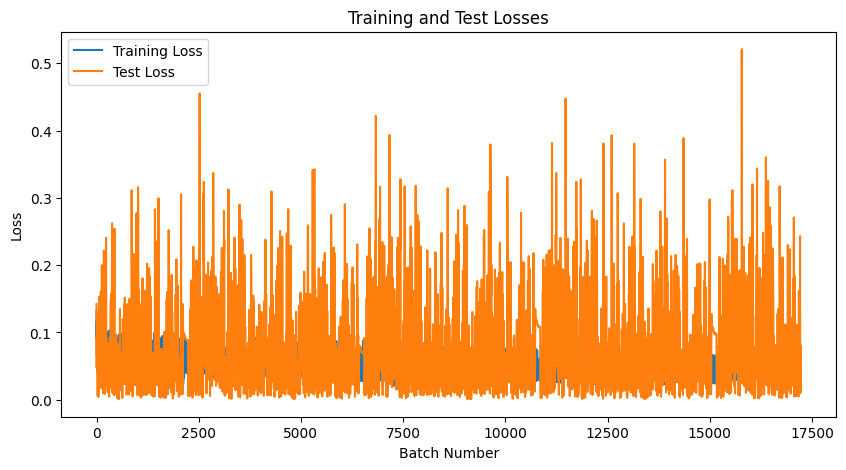

In [22]:
#TODO: plot the two arrays (be carefull they will not be the same length) Stretch the smaller oine it should fit approximatly
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test Loss')  # Stretching the test loss plot
plt.title('Training and Test Losses')

plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
torch.save(net.state_dict(), AccelRNNModelPath)

# Visualization

In [24]:
def DrawPicture(file, net, Seq_Length):
  print(file)
  net.eval()
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  targets = data[outputHeader]
  scaled_features = scaler.transform(features)
  sequences, targetsVector = create_sequences(scaled_features,targets, Seq_Length)
  print(sequences.shape)
  out= net(torch.Tensor(sequences)).detach().numpy()
  plt.plot(targetsVector,label='original Accel',color='b')
  plt.plot(out,label='predicted Accel',color='r')
  # plt.ylim(-1,1)
  plt.legend()
  plt.show()


./GeneratedDataDouble/CP5_NYC24_1A.feather
(412, 13, 10)


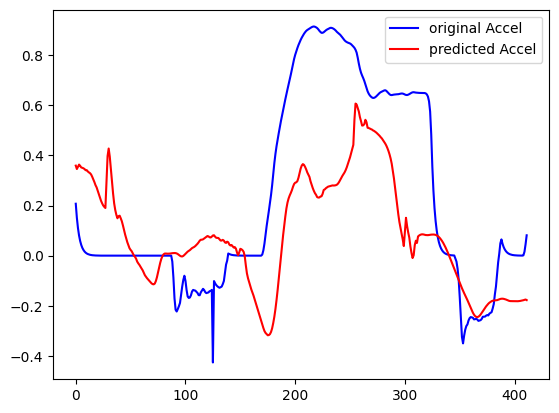

In [26]:
DrawPicture('./GeneratedDataDouble/CP5_NYC24_1A.feather', net, Seq_Length)

In [118]:
OutDict={}
for file in FileList:
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  original = data[outputHeader]
  scaled_features = scaler.transform(features)
  sequences, orin = create_sequences(scaled_features,original, Seq_Length)
  if(sequences.shape[0]==0):
    print("Not enoughData:",file)
    continue
  out= net(torch.Tensor(sequences)).detach().numpy()
  out = out.squeeze()
  value = np.power((orin-out),2).sum()/out.shape[0]
  OutDict[file] = value

In [119]:
TrainOutDict={}
TestOutDict={}
for file in train_files:
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  original = data[outputHeader]
  scaled_features = scaler.transform(features.values)
  sequences, orin = create_sequences(scaled_features,original, Seq_Length)
  if(sequences.shape[0]==0):
    print("Not enoughData:",file)
    continue
  out= net(torch.Tensor(sequences)).detach().numpy()
  out = out.squeeze()
  value = np.power((orin-out),2).sum()/out.shape[0]
  TrainOutDict[file] = value

for file in test_files:
  data = pd.read_feather(file)
  features = data[HeaderWithoutAccel]
  original = data[outputHeader]
  scaled_features = scaler.transform(features.values)
  sequences, orin = create_sequences(scaled_features,original, Seq_Length)
  if(sequences.shape[0]==0):
    print("Not enoughData:",file)
    continue
  out= net(torch.Tensor(sequences)).detach().numpy()
  out = out.squeeze()
  value = np.power((orin-out),2).sum()/out.shape[0]
  TestOutDict[file] = value

In [120]:
OutDict = dict(sorted(OutDict.items(), key=lambda item: item[1], reverse=True))

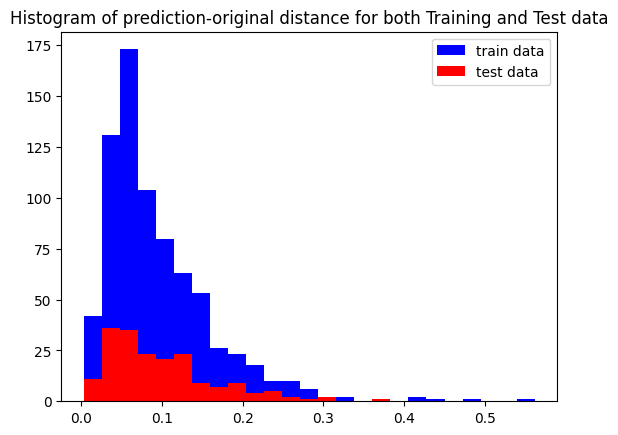

In [121]:
array = np.array([*OutDict.values()], dtype=object)
TrainValues = np.array([*TrainOutDict.values()], dtype=object)
TestValues = np.array([*TestOutDict.values()], dtype=object)
bin_edges = np.histogram(array,bins=25)[1]
plt.hist(TrainOutDict.values(), bin_edges, color='blue',label="train data")
plt.hist(TestOutDict.values(), bin_edges, color='red',label="test data")
plt.title("Histogram of prediction-original distance for both Training and Test data")
plt.legend()
plt.show()

In [122]:
print(TrainValues.mean(),TrainValues.std(), TestValues.mean(),TestValues.std())

0.09466612314783018 0.06668728417349348 0.09789943306979718 0.06640684337161909


- Before: 
    - 0.08628943166879526 
    - 0.05825990439165035 
    - 0.1157918683284439 
    - 0.07935516746882243
- MSE: 
    - 0.07196005030842437 
    - 0.043725020769293355 
    - 0.1096362819720668 
    - 0.07479438037540119
- Huber Loss(epoch 3):
    - 0.08272277910462089
    - 0.057262226937318014
    - 0.09667509893825163
    - 0.0679172731295205
- Huber Loss(epoch 4):
    - 0.09466612314783018 0.06668728417349348 0.09789943306979718 0.06640684337161909


----- WORST-----
./GeneratedDataDouble/CP7_ISR30_1A.feather
(146, 15, 10)


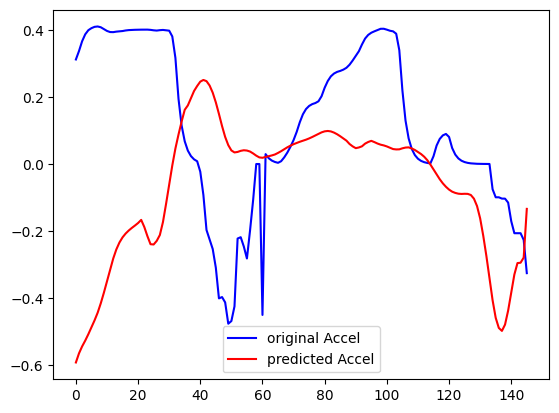

./GeneratedDataDouble/CP8_ISR29_1A.feather
(158, 15, 10)


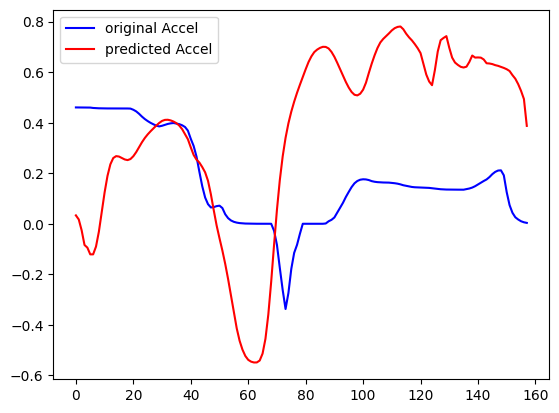

./GeneratedDataDouble/CP2_ISR05_1B.feather
(386, 15, 10)


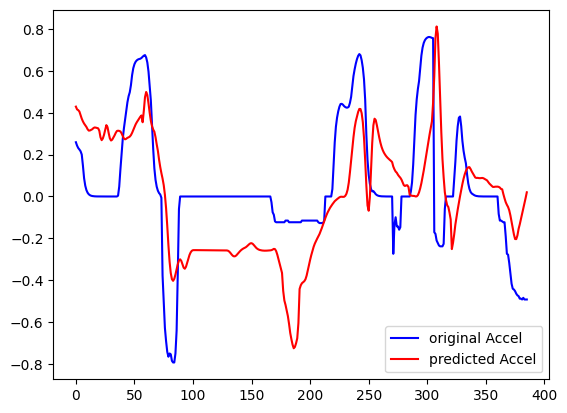

./GeneratedDataDouble/CP3_ISR09_1B.feather
(290, 15, 10)


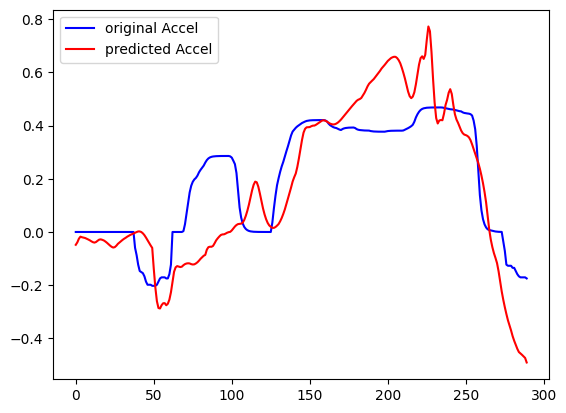

./GeneratedDataDouble/CP2_NYC13_1A.feather
(582, 15, 10)


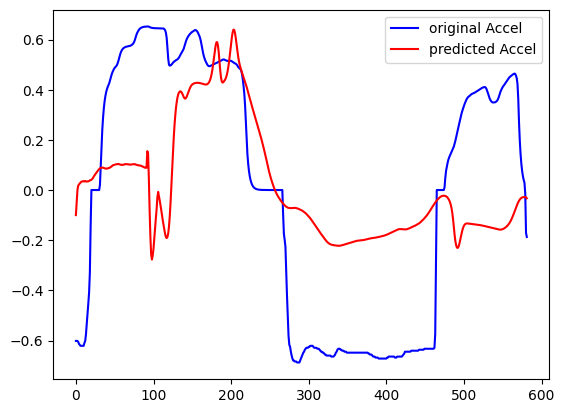

----- BEST-----
./GeneratedDataDouble/CP1_NYC32_1B.feather
(296, 15, 10)


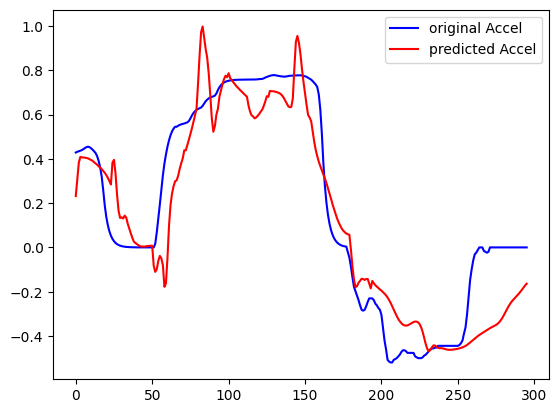

./GeneratedDataDouble/CP1_ISR26_1A.feather
(370, 15, 10)


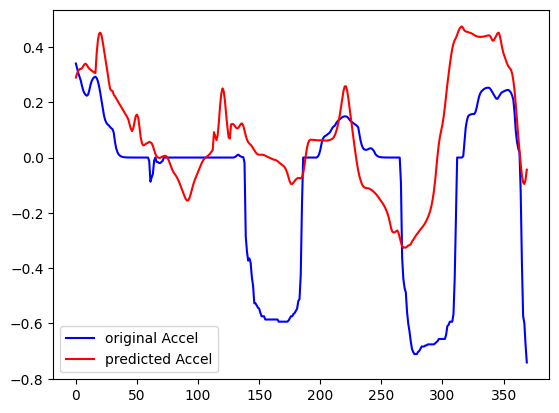

./GeneratedDataDouble/CP5_ISR22_1B.feather
(182, 15, 10)


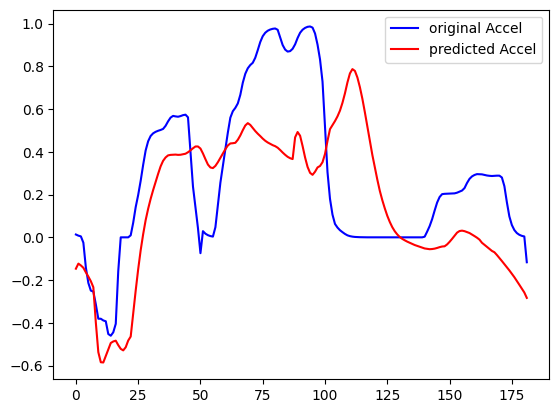

./GeneratedDataDouble/CP2_NYC15_1B.feather
(393, 15, 10)


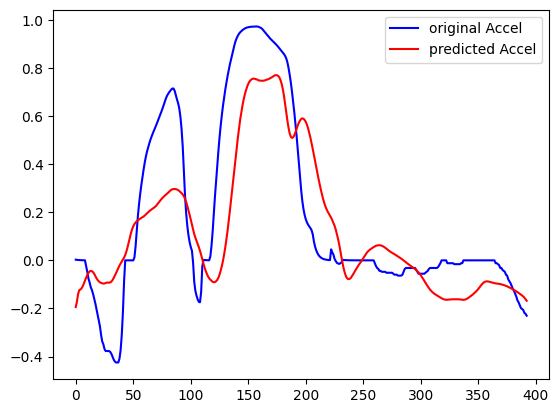

./GeneratedDataDouble/CP3_NYC6_1A.feather
(616, 15, 10)


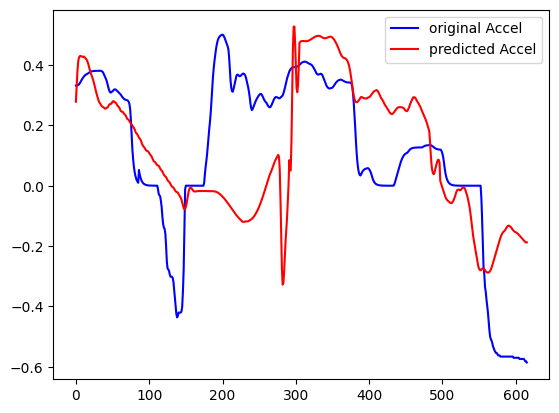

In [123]:
print("----- WORST-----")
DrawPicture(list(TestOutDict.keys())[0], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[1], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[2], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[3], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[4], net, Seq_Length)
print("----- BEST-----")
DrawPicture(list(TestOutDict.keys())[-1], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[-2], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[-3], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[-4], net, Seq_Length)
DrawPicture(list(TestOutDict.keys())[-5], net, Seq_Length)